In [2]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.ndimage import convolve
from scipy import signal
print('Libraries Imported')

Libraries Imported


In [3]:
##### create a 2D Gaussian kernl
def create_2d_gaussian(size=9, std=1.5):
    gaussian_1d = signal.gaussian(size,std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d/(gaussian_2d.sum())
    return gaussian_2d

# normalize image between 0 and 1
def normalize_img(img):
    normalized = (img - img.min())/(img.max() - img.min())    
    return normalized

In [4]:
# stack visualization
def visualize_stack(in_stack, levels, title):    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
    ax = ax.flatten()
    for i in range(levels):
        ax[i].imshow(in_stack[i], cmap='gray')
        ax[i].axis('off')
    plt.suptitle(title)
    plt.show()    
    
# build Gaussian and Laplacian stack of height levels (img is single channel)
def gaussian_and_laplacian_stack(img, levels):
    gaussian = create_2d_gaussian(size=17, std=3)
    gaussian_stack = []
    img_gaussian = img.copy()
    for i in range(levels):
        if i == 0:
            gaussian_stack = [img_gaussian]
        else:
            gaussian_stack.append(convolve(gaussian_stack[-1], gaussian, mode='reflect'))
    
    laplacian_stack = []
    #
    # YOUR CODE HERE: create Laplcian stack and pack into the same type of data structure as gaussian_stack
    laplacian_stack = []
    
    for i in range(levels):
            if i == levels-1:
                laplacian_stack.append(gaussian_stack[i])
            else:
                l1 = gaussian_stack[i]
                l2 = gaussian_stack[i+1]
                laplacian = l1-l2
                laplacian = laplacian - np.min(laplacian)
                laplacian = laplacian/np.max(laplacian)
                laplacian_stack.append(laplacian)
    
    return (gaussian_stack, laplacian_stack)

# collapse Laplacian stack into single image
def collapse_laplacian_stack(laplacian_stack):
    #
    # YOUR CODE HERE: collapse a Laplacian stack returning a single image
    img_orig = laplacian_stack[len(laplacian_stack)-1]
    print(img_orig.shape)
    rows,columns = img_orig.shape[0],img_orig.shape[1]
    final_image = np.zeros((rows,columns))
    
    for image in laplacian_stack:
        final_image += image
    return final_image
    
    
# create new (blended) stack by combining invidivual stack levels
def create_blended_stack(ls1, ls2, gs):
    #
    # YOUR CODE HERE: create and return a stack that blends Laplacian stacks ls1 and ls2
    #                 with mask in Gaussian stack gs
    levels = len(ls1)
    blended_stacks = []
    
    #The kth level of a blended stack is: (Gk x L1k) + (1-Gk) x L2k, where Gk is the kth level of the 
    #Gaussian stack (of the mask) and L1k and L2k are the kth levels of the Laplacian stacks 
    #(of the two input images).

    for k in range(levels):
        Gk = gs[k]
        L1k = ls1[k]
        L2k = ls2[k]
        
        blended_stacks.append((Gk*L1k)+(1-Gk)*L2k)
    return blended_stacks
        

# perofrm image blending 
def multires_blending(img1, img2, mask, levels):
    gs_1, ls_1 = gaussian_and_laplacian_stack(img1, levels)
    gs_2, ls_2 = gaussian_and_laplacian_stack(img2, levels)
    gs_m, _    = gaussian_and_laplacian_stack(mask, levels)
    blended_ls = create_blended_stack(ls_1, ls_2, gs_m) # blend
    return collapse_laplacian_stack(blended_ls)

In [5]:
import cv2

def read_resize_normalize_image(path="",size=""):
    """
    This Function imports an image and normalizes it and resizes it and uses only channel 0 for simplicity
    """
    image = 1.0*plt.imread(path)
    
    shape = image.shape
    
    if len(shape)>2:
        image = image[:,:,0]
    
    if np.max(image) == 255.0:
        image = image/255.0
        
    image = cv2.resize(image,dsize=size,interpolation=cv2.INTER_CUBIC)
    plt.imshow(image)
    return image

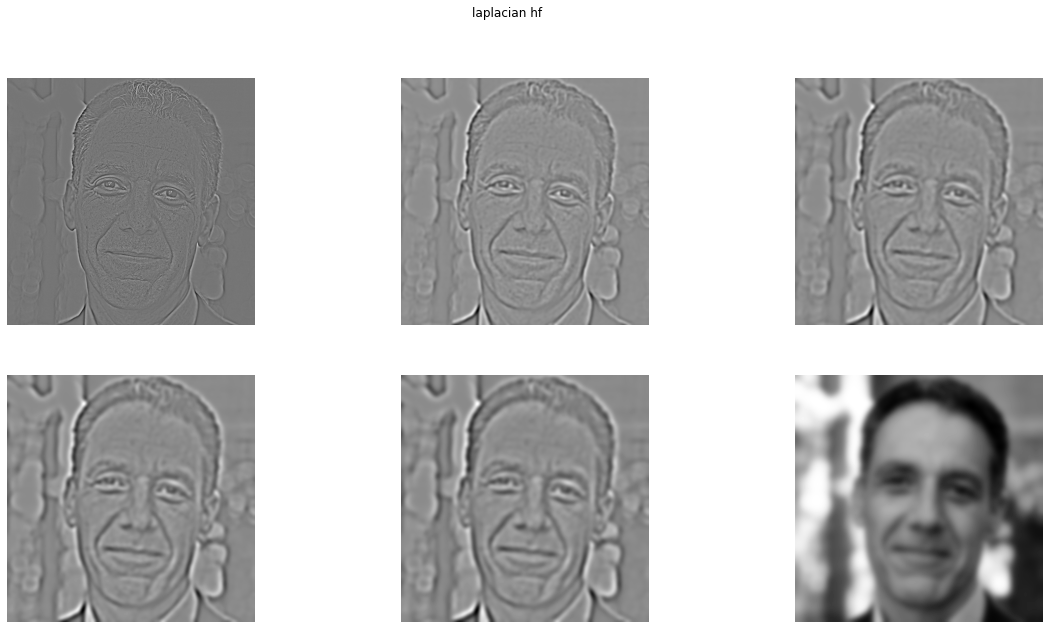

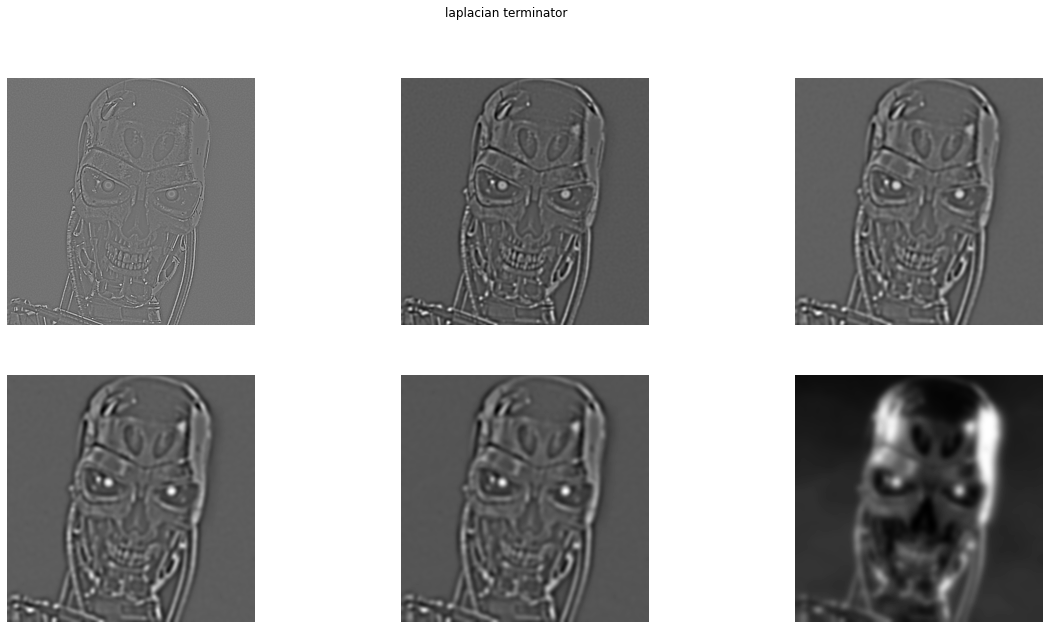

In [18]:
# load images
#path = "Everest_day.png"
#path2 = "Everest_morning.png"

size = (600,600)
#im1 = read_resize_normalize_image(path,size)
im1 = plt.imread( "a4-hf.png" )

im2 = plt.imread( "a4-terminator.png" )
#im2 = read_resize_normalize_image(path2,size)
msk = plt.imread( "a4-mask.png" )

# create Gaussian and Laplacian stacks

levels     = 6
gs_a, ls_a = gaussian_and_laplacian_stack(im1, levels)
gs_o, ls_o = gaussian_and_laplacian_stack(im2, levels)
gs_m, _    = gaussian_and_laplacian_stack(msk, levels)

# visualize all the stacks
visualize_stack(ls_a, levels, title='laplacian hf')
visualize_stack(ls_o, levels, title='laplacian terminator')



(600, 600)


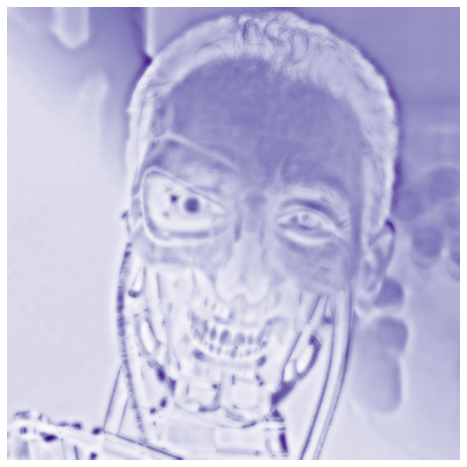

In [19]:
blend = normalize_img(multires_blending(im1, im2, msk, levels))

dpi  = 72.0 
height, width = blend.shape
figsize = width/dpi, height/dpi
plt.figure(figsize=figsize)
plt.imshow(blend,cmap="Purples")
plt.axis("off")
#plt.gray()
plt.show()


In [8]:
im1.shape

(600, 600)

In [9]:
im2.shape

(600, 600)

In [10]:
msk.shape

(600, 600)